In [60]:
import pandas as pd
import numpy as np
from math import atan2, radians, pi
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
cols = ['Permanent_Tournament_#','Round','Hole','Start_X_Coordinate','Start_Y_Coordinate','Year']
add_cols = ['End_X_Coordinate','End_Y_Coordinate','Strokes_from_starting_location','Course_#','Cat']

In [52]:
data = pd.concat([pd.read_csv('../data/%d.csv' % (year,), usecols=cols+add_cols) for year in range(2003,2004)])

In [53]:
hole_locs = {}
for tup,df in data.groupby(['Permanent_Tournament_#','Round','Hole','Year']):
    x,y = df.sort_values('Strokes_from_starting_location').iloc[0][['End_X_Coordinate','End_Y_Coordinate']]
    hole_locs[tuple(map(int,tup))] = (x,y)

In [54]:
data['Distance_from_hole'] = [((hole_locs[tuple(np.concatenate([tup[:-3],tup[-1:]]))][0] - tup[-3])**2 + 
                               (hole_locs[tuple(np.concatenate([tup[:-3],tup[-1:]]))][1] - tup[-2])**2)**.5
                              for tup in data[cols].values]

In [ ]:
def wrap(angle):
    if angle > pi:
        return angle - 2*pi
    elif angle < -pi:
        return angle + 2*pi
    else:
        return angle

def get_sub(df,angle,slack):
    bottom, top = angle-slack, angle+slack
    _or = (abs(bottom)>pi) or (abs(top)>pi)
    bottom, top = wrap(bottom), wrap(top)
    return df[(df.angle>bottom) | (df.angle<top)] if _or else df[(df.angle>bottom) & (df.angle<top)]

In [93]:
grouped = data.groupby(['Course_#','Round','Hole','Year'])
print len(grouped)
for i,((course,round,hole,year),df) in enumerate(grouped):
    if i==21: break

2548


In [94]:
df = df.copy()
hole_x, hole_y = df[df.Strokes_from_starting_location==1].iloc[0][['End_X_Coordinate','End_Y_Coordinate']]
df.Start_X_Coordinate = df.Start_X_Coordinate - hole_x
df.Start_Y_Coordinate = df.Start_Y_Coordinate - hole_y
df.End_X_Coordinate = df.End_X_Coordinate - hole_x
df.End_Y_Coordinate = df.End_Y_Coordinate - hole_y
non_green = df[df.Cat!='Green']
green = df[df.Cat=='Green']
green.insert(len(green.columns),'angle',[atan2(y,x) for x,y in zip(green.Start_X_Coordinate,green.Start_Y_Coordinate)])

In [97]:
work_with = []
for u,(x,y) in enumerate(zip(non_green.Start_X_Coordinate,non_green.Start_Y_Coordinate)):
    angle = atan2(y,x)
    slack = 12
    sub = get_sub(green,angle,radians(slack))
    c = 0
    # if len(sub)==0:
    #     print green.angle.sort_values().values
    while len(sub)==0:
        #print u,c,len(green),x,y,angle,slack,radians(slack)
        c += 1
        slack += .5
        if c==134:
            break
        sub = get_sub(green,angle,radians(slack))
    if c==134:
        work_with.append(np.nan)
    else:
        work_with.append(sub.Distance_from_hole.max())
#assert np.all(data[(data['Course_#']==course) & (data.Round==round) & (data.Hole==hole) & (data.Cat!='Green')].index==non_green.index)
non_green.loc[non_green.index,'Green_to_work_with'] = work_with

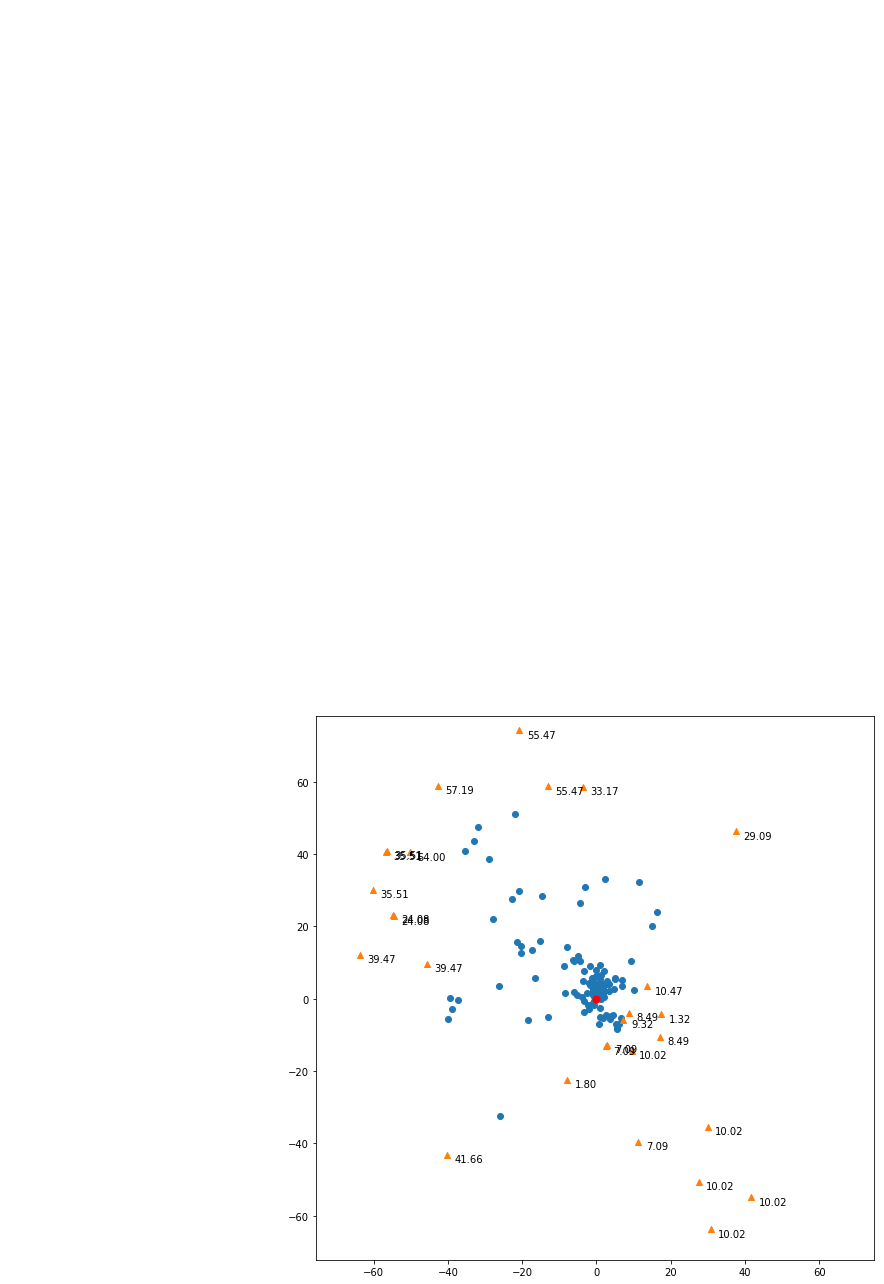

In [98]:
plt.subplots(1,1,figsize=(10,10))
plt.scatter(green.Start_X_Coordinate,green.Start_Y_Coordinate);
x_range = green.Start_X_Coordinate.max()-green.Start_X_Coordinate.min()
y_range = green.Start_Y_Coordinate.max()-green.Start_Y_Coordinate.min()
range_ = max([x_range,y_range])*.9
plt.xlim(green.Start_X_Coordinate.median()-range_,green.Start_X_Coordinate.median()+range_)
plt.ylim(green.Start_Y_Coordinate.median()-range_,green.Start_Y_Coordinate.median()+range_);
plt.scatter([0],[0],c='r',s=50);
plt.scatter(non_green.Start_X_Coordinate,non_green.Start_Y_Coordinate,marker="^");
for row_ind,row in non_green.iterrows():
    plt.annotate('%.2f' % row.Green_to_work_with,(row.Start_X_Coordinate+2,row.Start_Y_Coordinate-2))